<a href="https://colab.research.google.com/github/afaqahmed91/deeplearning/blob/main/notebooks/practice/pytorch_lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving Alcohol_Sales.csv to Alcohol_Sales.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
df = pd.read_csv("Alcohol_Sales.csv", index_col = "DATE", parse_dates = True)
df.index.freq = "MS"

In [3]:
df.head()

,S4248SM144NCEN
DATE,
1992-01-01,3459
1992-02-01,3458
1992-03-01,4002
1992-04-01,4564
1992-05-01,4221


<Axes: xlabel='DATE'>

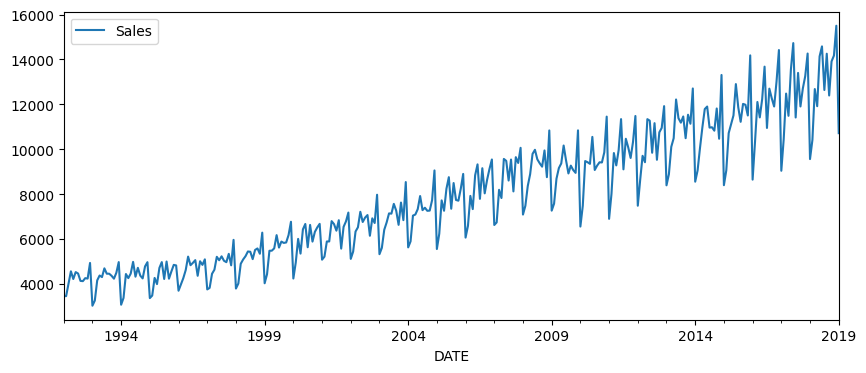

In [4]:
df.columns = ["Sales"]
df.plot(figsize = (10,4))

In [192]:
seq_length = 12
no_seq = 2
train = df.iloc[:-(seq_length * no_seq)]
test = df.iloc[-(seq_length * (no_seq+1)) :]

In [185]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [194]:
sale_train =train.to_numpy().reshape(-1, 1)
sale_test = test.to_numpy().reshape(-1, 1)


In [195]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)

sale_train = scaler.transform(train)
sale_test = scaler.transform(test)

In [196]:
def to_sequences(seq_size: int, obs):
    input_batch = []
    output_batch = []
    for i in range(len(obs) - seq_size):
        window = obs[i:(i + seq_size)]
        after_window = obs[i + seq_size]
        input_batch.append(window)
        output_batch.append(after_window)
    x_batch = np.array(input_batch)
    y_batch = np.array(output_batch)
    return torch.tensor(x_batch, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y_batch, dtype=torch.float32).view(-1, 1)


In [197]:

X_train, y_train = to_sequences( seq_length, sale_train)
X_test, y_test = to_sequences( seq_length, sale_test)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

(torch.Size([289, 12, 1]),
 torch.Size([289, 1]),
 torch.Size([24, 12, 1]),
 torch.Size([24, 1]))

In [198]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)



In [199]:
from torch.utils.data import DataLoader

batch_size = 16

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [200]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cpu'

**Figure 10.ILSTM: Inside a LSTM Layer**  
![LSTM Layers](https://raw.githubusercontent.com/jeffheaton/t81_558_deep_learning/master/images/class_10_lstm2.png "Inside the LSTM")


You have to initialize C_0 and H_0 to zeros to start the training -> they can be done better

In [203]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output):
        super().__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, 1, batch_first=True)
        self.dropout = nn.Dropout(p=0.2)
        self.fc1 = nn.Linear(hidden_size , hidden_size //2 )
        self.fc2 = nn.Linear(hidden_size //2  , output)

    def forward(self, x):
        # Initialize hidden state and cell state with zeros
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)

        # Pass through LSTM layer
        out, (hn, cn) = self.lstm(x, (h0, c0))

        # Pass through fully connected layers
        out = self.dropout(out[:, -1, :])  # We only want the output of the last time step
        out = self.fc1(out)
        out = F.relu(out)
        out = self.fc2(out)

        return out

In [204]:
input_size = 1
hidden_size = 300
output = 1
model = LSTM(input_size, hidden_size, output)
model.to(device)

LSTM(
  (lstm): LSTM(1, 300, batch_first=True)
  (dropout): Dropout(p=0.2, inplace=False)
  (fc1): Linear(in_features=300, out_features=150, bias=True)
  (fc2): Linear(in_features=150, out_features=1, bias=True)
)

In [222]:
criterion = nn.MSELoss()
learning_rate = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [223]:
def train_one_epoch():
    model.train(True)
    print(f'Epoch: {epoch + 1}')
    running_loss = 0.0

    for batch_index,(x_batch, y_batch) in enumerate(train_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)

        output = model.forward(x_batch)
        loss = criterion(output, y_batch)
        running_loss += loss.item()

        # calculate the gradient
        loss.backward()
         # update the weights
        optimizer.step()
        # zero the gradients after updating
        optimizer.zero_grad()

        if batch_index % 5 == 4:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print(f'Batch {batch_index+1}, Loss: {avg_loss_across_batches}')
            running_loss = 0.0
    print()

In [224]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    for batch_index, (x_batch, y_batch) in enumerate(test_loader):
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        with torch.no_grad():
            output = model(x_batch)
            loss = criterion(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)

    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()
    return running_loss

In [219]:
early_stop_count = 0
min_val_loss = float('inf')

In [248]:
num_epochs = 2000
for epoch in range(num_epochs):
    train_one_epoch()
    val_loss = validate_one_epoch()

    if val_loss < min_val_loss:
        min_val_loss = val_loss
        early_stop_count = 0
    else:
        early_stop_count += 1

    if early_stop_count >= 50:
        print("Early stopping!")
        break
    print(f"Epoch {epoch + 1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

Epoch: 1
Batch 5, Loss: 0.0002822791319340467
Batch 10, Loss: 0.00031269045546650887
Batch 15, Loss: 0.00026190494885668157

Val Loss: 0.014
***************************************************

Epoch 1/2000, Validation Loss: 0.0273
Epoch: 2
Batch 5, Loss: 0.00024093520594760775
Batch 10, Loss: 0.00020100631285458804
Batch 15, Loss: 0.00037037590518593786

Val Loss: 0.014
***************************************************

Epoch 2/2000, Validation Loss: 0.0282
Epoch: 3
Batch 5, Loss: 0.000397803639061749
Batch 10, Loss: 0.00040610930416733025
Batch 15, Loss: 0.0002610940439626574

Val Loss: 0.015
***************************************************

Epoch 3/2000, Validation Loss: 0.0306
Epoch: 4
Batch 5, Loss: 0.00023794296430423856
Batch 10, Loss: 0.0003137735463678837
Batch 15, Loss: 0.00021729817613959314

Val Loss: 0.013
***************************************************

Epoch 4/2000, Validation Loss: 0.0269
Epoch: 5
Batch 5, Loss: 0.00026073197601363064
Batch 10, Loss: 0.00031660

In [249]:
with torch.no_grad():
  predictions = model.forward(X_train.to(device))

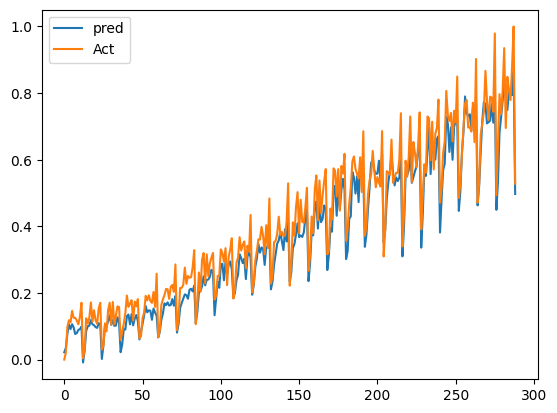

In [250]:
plt.plot(predictions.numpy().squeeze(), label = "pred")
plt.plot(sale_train[12:], label = "Act")
plt.legend()

In [251]:
# Forecast
def generate_forecast(model, input_eval, generation_length=12):
  # Empty string to store our results
  predictions = []


  with torch.no_grad():
      for i in range(generation_length):
        prediction = model.forward(input_eval.to(device))
        predictions.append(prediction.tolist())
        input_eval = torch.tensor(np.append(input_eval[:, 1:,:], prediction.reshape(1,1,1))).float().reshape(1,12,1)

  return np.array(predictions)

In [252]:
X_test[0]

tensor([[0.6400],
        [0.7968],
        [0.7365],
        [0.8083],
        [0.9350],
        [0.6953],
        [0.8489],
        [0.8113],
        [0.7791],
        [0.8766],
        [1.0000],
        [0.5278]])

In [253]:
input_eval = X_test[0].reshape(1,seq_length, 1)

In [254]:
predictions = generate_forecast(model, input_eval, 24)

In [255]:
true_predictions = scaler.inverse_transform(predictions.squeeze().reshape(-1,1))

In [256]:
validate = test.iloc[-24:]

In [257]:
validate["Predictions"] = true_predictions

<ipython-input-257-6954ed153a77>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validate["Predictions"] = true_predictions


<Axes: xlabel='DATE'>

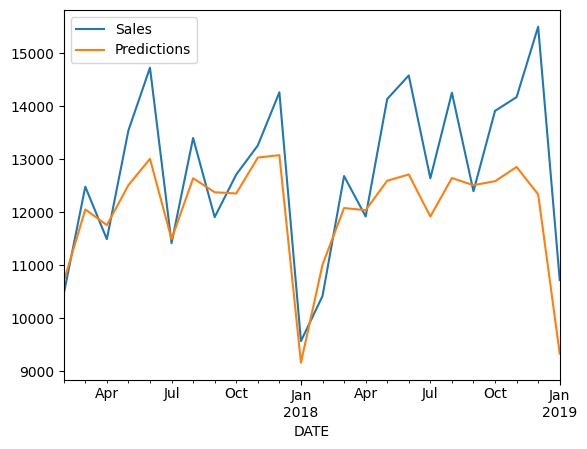

In [258]:
validate.plot()

Val Loss: 0.013
***************************************************



0.026349048130214214